# In class exercises for 11.21.2018 (Filtering)

## First import data from eeg_data00.npz

In [6]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import our sinc filter implementation function...
import my_sinc_filt as msf

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [7]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

print("\nThere are",data.shape[0],"trials (rows)")
print("There are",data.shape[1],"timepoints per trial (columns)")

Shape of the big eeg data set:  (960, 876)
Sample rate:  250

There are 960 trials (rows)
There are 876 timepoints per trial (columns)


## Extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

In [8]:
# Create a time window, just like in Tutorial_042_Exercises
window = (tx >= 0) & (tx < 2000)

# Select data matching the window
dataWindow = data[:,window]

# Select tx matching the window
timeWindow = tx[window]

## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

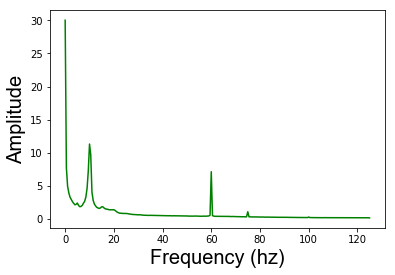

In [99]:
# Get the shape of the data
rows,columns = dataWindow.shape

# FFT each trial
dataFFT = np.fft.rfft(dataWindow, axis = 1)

# Get amplitude on each trial
amplitude = (np.abs(dataFFT) / columns) * 2

# Get average amplitude across trials
amplitudeAcrossTrials = np.mean(amplitude, axis = 0)

# Get frequency
frequency = np.fft.rfftfreq(columns, 1 / sr)

# Plot 
plt.plot(frequency, amplitudeAcrossTrials, "g")
plt.xlabel("Frequency (hz)", **fig_font)
plt.ylabel("Amplitude", **fig_font)
plt.show()

## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial

In [75]:
# About the custom-made define_filt() function:
#    Args:
#        fc (float): cutoff frequency, as a fraction of sampling rate
#        b (float): transition band, as a fraction of sampling rate
#        window (str): window sinc filter, options 'none', 'blackman', 'hanning'
#        type_filt (str): low pass or high pass filter, options 'lp', 'hp'
#     Returns:
#         n (int array): span of filter
#         sinc (float array): sinc filter in time domain

# About custom-made apply_filter() function:
#    input_sig = timeseries to be filtered
#    input_filter = filter to be applied

# Define maximum desired frequency
maxFrequency = 20

# Create filter arguments
cutoffFrequency = maxFrequency / sr # converts hz to cutoff frequency
transitionBand = 0.1
windowSincFilter = "blackman"
filterType = "lp"

# Generate a low pass filter using our previously defined function
filterSpan, sincFilter = msf.define_filt(fc = cutoffFrequency, 
                               b = transitionBand, 
                               window = windowSincFilter, 
                               type_filt = filterType)

# Create empty matrix to fill with loop below
dataFiltered = np.zeros((rows,columns))

# Loop through trials to apply filter with our previously defined function
for row in np.arange(rows):
    dataFiltered[row,:] = msf.apply_filt(input_sig = dataWindow[row,:],
                                         input_filter = sincFilter)

## Then FFT it again to see if you got rid of the hf components of the signal

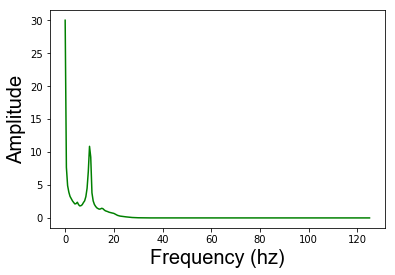

The spikes at 60hz and above are now gone!


In [100]:
# Get the shape of the data
rows,columns = dataFiltered.shape

# FFT each trial
dataFilteredFFT = np.fft.rfft(dataFiltered, axis = 1)

# Get amplitude on each trial
amplitude = (np.abs(dataFilteredFFT) / columns) * 2

# Get average amplitude across trials
amplitudeAcrossTrials = np.mean(amplitude, axis = 0)

# Get frequency
frequency = np.fft.rfftfreq(columns, 1 / sr)

# Plot 
plt.plot(frequency, amplitudeAcrossTrials, "g")
plt.xlabel("Frequency (hz)", **fig_font)
plt.ylabel("Amplitude", **fig_font)
plt.show()

print("The spikes at 60hz and above are now gone!")

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter (with an appropriate fc), then make a hp filter (with an appropriate fc)
* use np.convolve to combine the two filters 
* then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

In [77]:
# Define the range we want to filter out
bandPassRange = [6, 14]

# Low pass filter parameters
cutoffFrequencyLP = bandPassRange[0] / sr
transitionBandLP = 0.1
windowSincFilterLP = "blackman"
filterTypeLP = "lp"

# High pass filter parameters
cutoffFrequencyHP = bandPassRange[1] / sr
transitionBandHP = 0.1
windowSincFilterHP = "blackman"
filterTypeHP = "hp"

# Build low pass filter
filterSpan, sincFilterLP = msf.define_filt(fc = cutoffFrequencyLP,
                                           b = transitionBandLP,
                                           window = windowSincFilterLP,
                                           type_filt = filterTypeLP)

# Build high pass filter
filterSpan, sincFilterHP = msf.define_filt(fc = cutoffFrequencyHP,
                                           b = transitionBandHP,
                                           window = windowSincFilterHP,
                                           type_filt = filterTypeHP)

# Combine the filters
bandPassFilter = np.convolve(sincFilterLP, sincFilterHP)

# Create empty matrix to fill with loop below
dataBandPassFilter = np.zeros((rows,columns))

# Loop through trials to apply filter
for row in np.arange(rows):
    dataBandPassFilter[row,:] = msf.apply_filt(input_sig = dataWindow[row,:],
                                               input_filter = bandPassFilter)

## Here's what the band pass filter looks like!

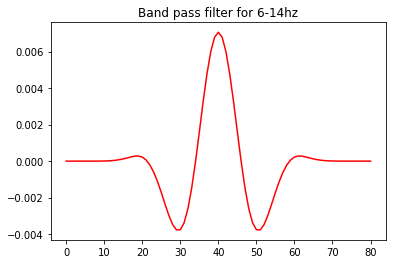

In [84]:
plt.plot(bandPassFilter, "r")
plt.title("Band pass filter for 6-14hz")
plt.show()

## Now FFT and look at filtered signal

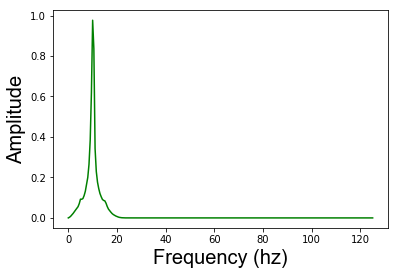

Now we're just left with one little spike at ~15hz


In [101]:
# Get the shape of the data
rows,columns = dataBandPassFilter.shape

# FFT each trial
dataBandPassFilterFFT = np.fft.rfft(dataBandPassFilter, axis = 1)

# Get amplitude on each trial
amplitude = (np.abs(dataBandPassFilterFFT) / columns) * 2

# Get average amplitude across trials
amplitudeAcrossTrials = np.mean(amplitude, axis = 0)

# Get frequency
frequency = np.fft.rfftfreq(columns, 1 / sr)

# Plot 
plt.plot(frequency, amplitudeAcrossTrials, "g")
plt.xlabel("Frequency (hz)", **fig_font)
plt.ylabel("Amplitude", **fig_font)
plt.show()

print("Now we're just left with one little spike at ~15hz")

## You can also make a band-stop filter using a similar logic
* Instead of convolving the lp and the hp filters, you can add them together
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

In [91]:
# Define the range we want to filter out
bandStopRange = [50, 70]

# Low pass filter parameters
cutoffFrequencyLP = bandStopRange[0] / sr
transitionBandLP = 0.1
windowSincFilterLP = "blackman"
filterTypeLP = "lp"

# High pass filter parameters
cutoffFrequencyHP = bandStopRange[1] / sr
transitionBandHP = 0.1
windowSincFilterHP = "blackman"
filterTypeHP = "hp"

# Build low pass filter
filterSpan, sincFilterLP = msf.define_filt(fc = cutoffFrequencyLP,
                                           b = transitionBandLP,
                                           window = windowSincFilterLP,
                                           type_filt = filterTypeLP)

# Build high pass filter
filterSpan, sincFilterHP = msf.define_filt(fc = cutoffFrequencyHP,
                                           b = transitionBandHP,
                                           window = windowSincFilterHP,
                                           type_filt = filterTypeHP)

# Combine the filters (by adding, rather than convolving)
bandStopFilter = sincFilterLP + sincFilterHP

# Create empty matrix to fill with loop below
dataBandStopFilter = np.zeros((rows,columns))

# Loop through trials to apply filter
for row in np.arange(rows):
    dataBandStopFilter[row,:] = msf.apply_filt(input_sig = dataWindow[row,:],
                                               input_filter = bandStopFilter)

## Here's what the band-stop filter looks like!

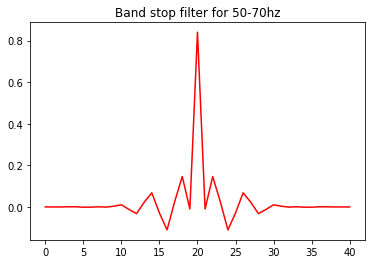

In [94]:
plt.plot(bandStopFilter, "r")
plt.title("Band stop filter for 50-70hz")
plt.show()

## Then FFT and look at filtered signal in the frequency domain

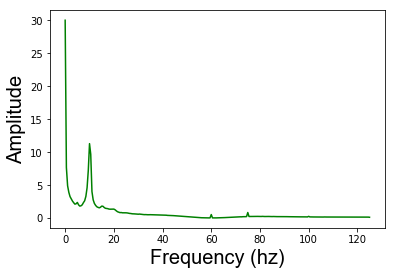

Now the spike at 60hz is greatly diminished!


In [102]:
# Get the shape of the data
rows,columns = dataBandStopFilter.shape

# FFT each trial
dataBandStopFilterFFT = np.fft.rfft(dataBandStopFilter, axis = 1)

# Get amplitude on each trial
amplitude = (np.abs(dataBandStopFilterFFT) / columns) * 2

# Get average amplitude across trials
amplitudeAcrossTrials = np.mean(amplitude, axis = 0)

# Get frequency
frequency = np.fft.rfftfreq(columns, 1 / sr)

# Plot 
plt.plot(frequency, amplitudeAcrossTrials, "g")
plt.xlabel("Frequency (hz)", **fig_font)
plt.ylabel("Amplitude", **fig_font)
plt.show()

print("Now the spike at 60hz is greatly diminished!")